# Befitting Bootstrap Analysis
> Ron S. Kenett, Chris Gotwalt, Laura Freeman, Peter Gedeck and Xinwei Deng


In [1]:
import common

In [2]:
import itertools
import random
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set random seed for reproducibility
In order to reproduce the results from the publication, the random seeds must be set to 123.

In [3]:
random.seed(123)
np.random.seed(123)

# Prepare dataset

In [4]:
# s, v0, k, t0 are mapped to x1, x2, x3, x4
data = common.preparePistonDataset()
data

,milliseconds,group,x1,x2,x3,x4
0,60.226485,1,-1.0,-1.0,-1.0,-1.0
1,65.020360,1,-1.0,-1.0,-1.0,-1.0
2,57.302374,1,-1.0,-1.0,-1.0,-1.0
3,50.978262,1,-1.0,-1.0,-1.0,-1.0
4,56.526159,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
155,68.963006,32,0.0,0.0,0.0,0.0
156,51.328098,32,0.0,0.0,0.0,0.0
157,51.372896,32,0.0,0.0,0.0,0.0
158,59.049678,32,0.0,0.0,0.0,0.0


# Build a variety of models using main effects and interactions

In [5]:
main_terms = 'x1 + x2 + x3 + x4'
main_terms_significant = 'x1 + x2 + x3'
interaction_terms = 'x1:x2 + x1:x3 + x2:x3'
quadratic_terms = 'I(x1**2) + I(x2**2) + I(x3**2)'
formula_main = f'milliseconds ~ {main_terms}'
formula_interaction = f'milliseconds ~ {main_terms_significant} + {interaction_terms}'
formula_quadratic = f'milliseconds ~ {main_terms_significant} + {quadratic_terms}'
formula_full = f'milliseconds ~ {main_terms_significant} + {interaction_terms} + {quadratic_terms}'
group = ['x1', 'x2', 'x3', 'x4']

In [6]:
results = {
    'ols_main': common.buildModel(data, formula_main),
    'ols_interaction': common.buildModel(data, formula_interaction),
    'ols_quadratic': common.buildModel(data, formula_quadratic),
    'ols_full': common.buildModel(data, formula_full),
}
results['ols_main'].summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,63.6518,0.823,77.302,0.000,62.025,65.278
x1,-15.5256,0.951,-16.329,0.000,-17.404,-13.647
x2,13.0152,0.951,13.689,0.000,11.137,14.893
x3,4.7356,0.951,4.981,0.000,2.857,6.614
x4,0.3212,0.951,0.338,0.736,-1.557,2.199


In [7]:
results['ols_full'].summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.3069,1.197,50.397,0.000,57.942,62.671
x1,-15.5256,0.788,-19.709,0.000,-17.082,-13.969
x2,13.0152,0.788,16.523,0.000,11.459,14.572
x3,4.7356,0.788,6.012,0.000,3.179,6.292
x1:x2,-4.9101,0.965,-5.089,0.000,-6.816,-3.004
x1:x3,-2.2820,0.965,-2.365,0.019,-4.188,-0.376
x2:x3,1.6966,0.965,1.759,0.081,-0.210,3.603
I(x1 ** 2),4.5094,0.708,6.370,0.000,3.111,5.908
I(x2 ** 2),0.2682,0.708,0.379,0.705,-1.131,1.667
I(x3 ** 2),-0.3178,0.708,-0.449,0.654,-1.717,1.081


In [8]:
# How often does bootstrap analysis remove whole groups
ngroups = len(set(data['group']))
missing = []
for _ in range(10_000):
    missing.append(ngroups - len(set(data.sample(frac=1, replace=True)['group'])))
(np.array([Counter(missing).get(n, 0) for n in range(5)]) / len(missing)).round(3)

array([0.814, 0.172, 0.013, 0.001, 0.   ])

# Bootstrap analysis

## 100 bootstrap samples

In [9]:
methods = {
    'BA': (common.bootstrapAnalysis, {}),
    'BBA': (common.befittingBootstrapAnalysis, {'group': group}),
    'pBBA': (common.parametricBefittingBootstrapAnalysis, {'group': group, 'seed': 123}),
    'pBA': (common.parametricBootstrapAnalysis, {}),
    'wBA': (common.wildBootstrapAnalysis, {}),
}

def compareMethods(results, nrepeats):
    for key, (method, additional_kwargs) in methods.items():
        kwargs = {'nrepeats': nrepeats, **additional_kwargs}
        results.update({
            f'{key}_main': method(data, formula_main, **kwargs),
            f'{key}_interaction': method(data, formula_interaction, **kwargs),
            f'{key}_quadratic': method(data, formula_quadratic, **kwargs),
            f'{key}_full': method(data, formula_full, **kwargs),
        })
    return results

results = compareMethods(results, 100)


Visualize the standard deviations for each coefficient

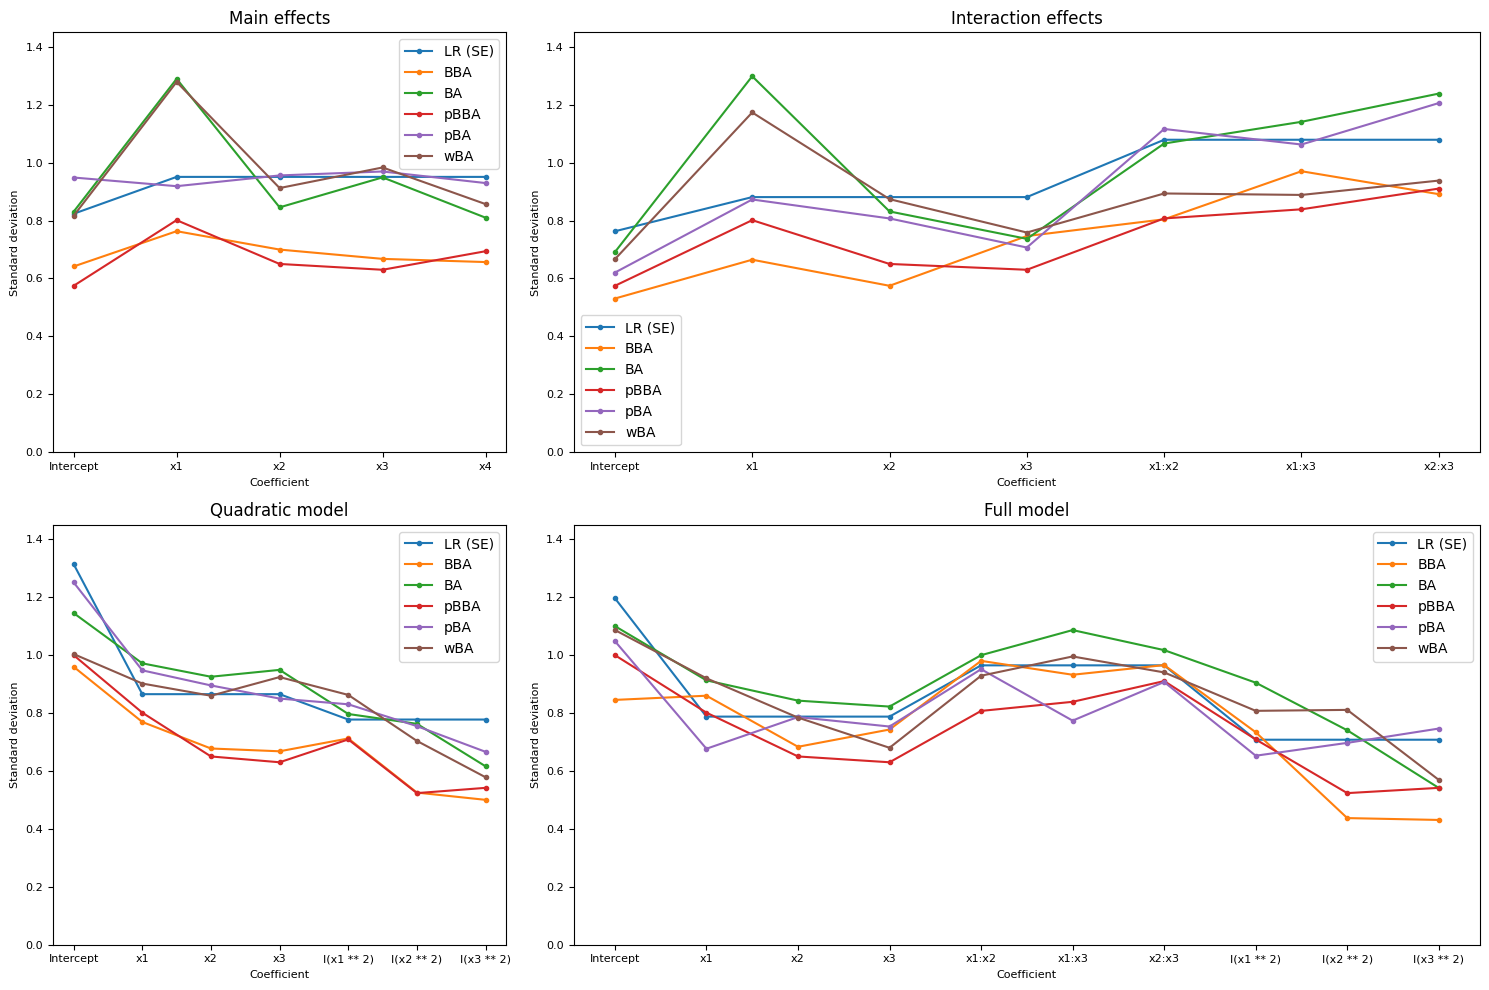

In [10]:
def summary_std_cofficients(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), width_ratios=[1, 2])
    axes = list(itertools.chain(*axes))

    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax = plot_std_coefficients(results['ols_interaction'], results['BBA_interaction'], results['BA_interaction'], 
                                    results['pBBA_interaction'], results['pBA_interaction'], results['wBA_interaction'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Interaction effects')
    ax.legend()
    ax = plot_std_coefficients(results['ols_quadratic'], results['BBA_quadratic'], results['BA_quadratic'], 
                                    results['pBBA_quadratic'], results['pBA_quadratic'], results['wBA_quadratic'], 
                                    ax=axes[2])
    ax.set_ylim(yrange)
    ax.set_title('Quadratic model')
    ax.legend()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[3])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()
summary_std_cofficients(results)

## 500 bootstrap samples

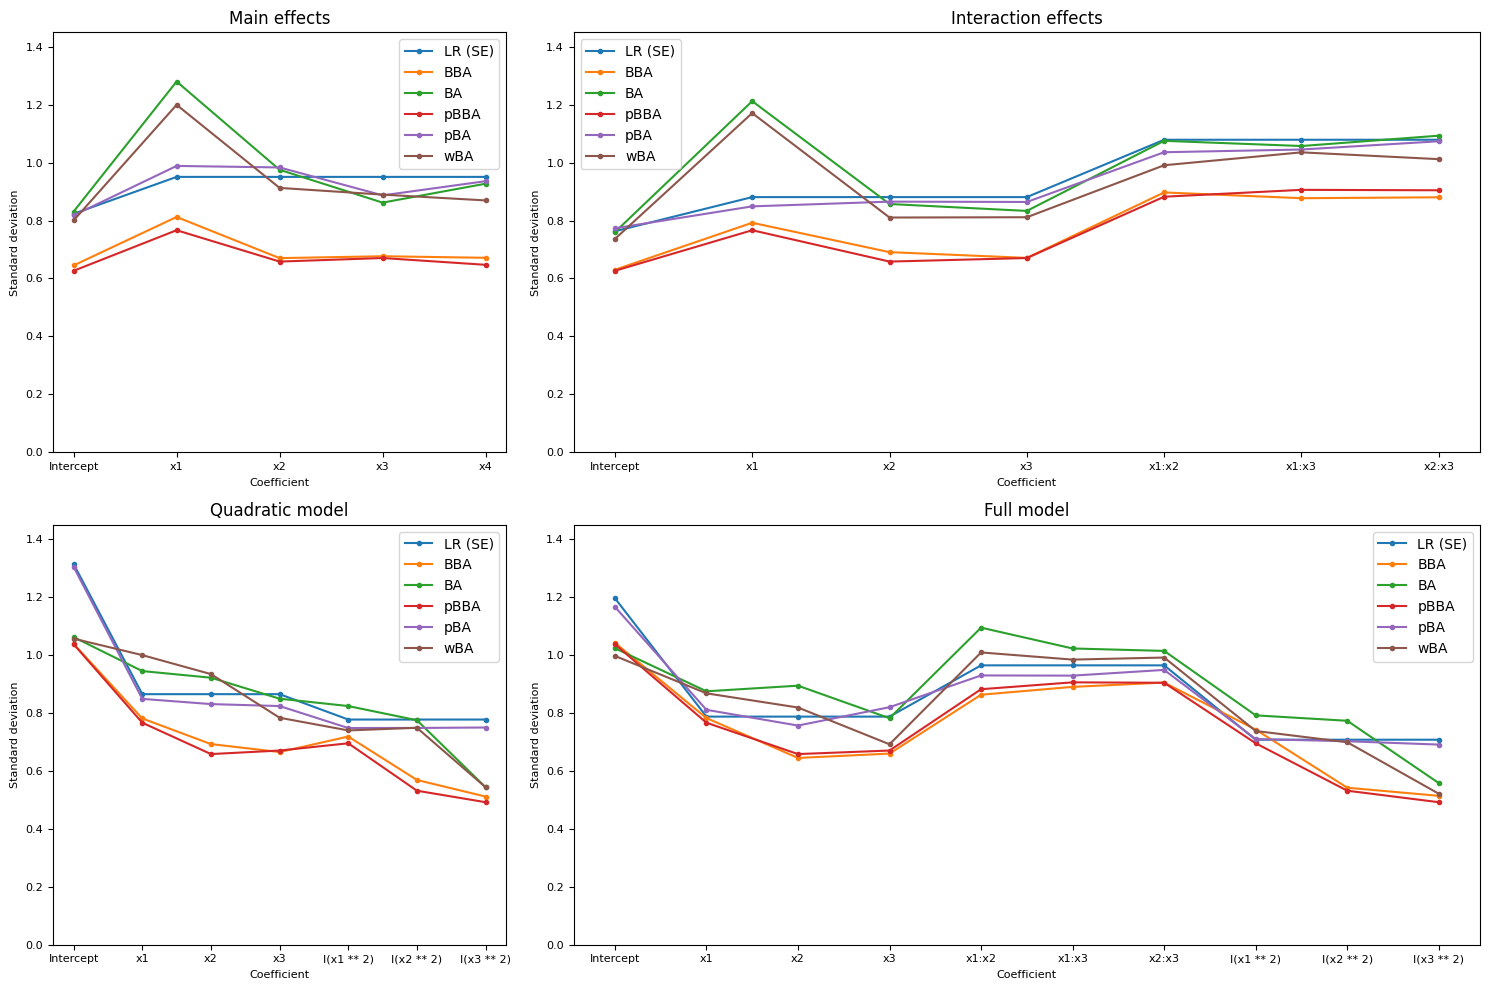

In [11]:
results = compareMethods(results, 500)

summary_std_cofficients(results)

## 1000 bootstrap samples

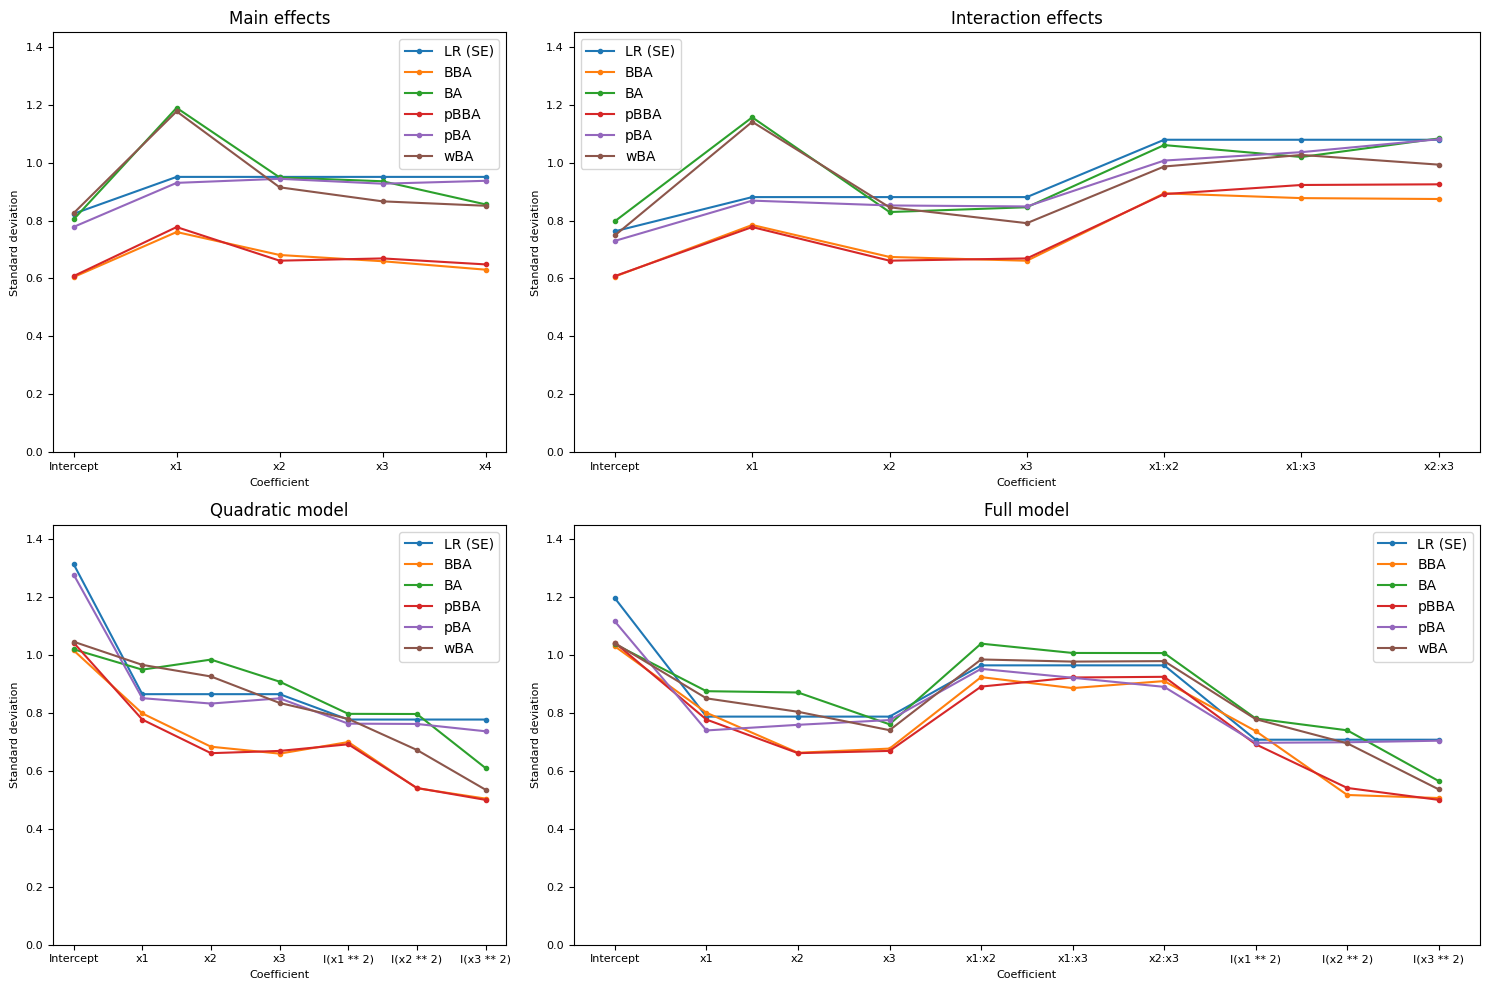

In [12]:
results = compareMethods(results, 1000)

summary_std_cofficients(results)

# Create summary tables for bootstrap results with 1000 samples
Analysis focuses on _main_ and _full_ models

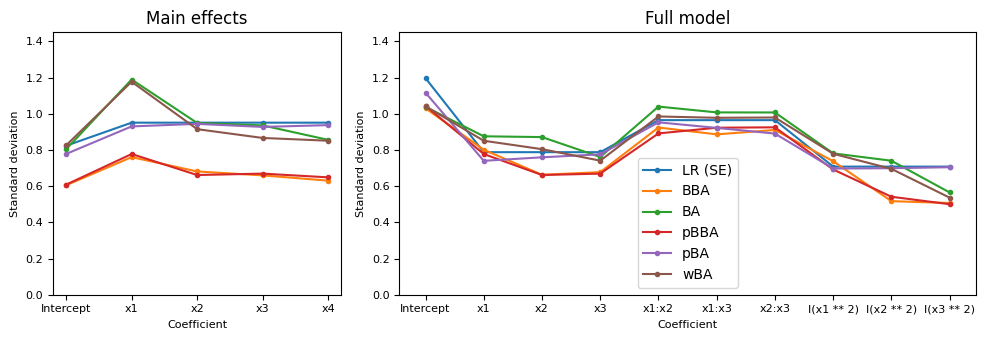

In [13]:
def summary_std_cofficients(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5), width_ratios=[1, 2])

    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax.get_legend().remove()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()

summary_std_cofficients(results)

In [14]:
models = {
    'main': 'Main',
    'full': 'Full',

}
for method in ('BBA', 'BA', 'pBBA', 'pBA', 'wBA'):
    sign_main = results['ols_main'].pvalues < 0.1
    sign_int = results['ols_interaction'].pvalues < 0.1
    comparison = pd.concat({
        v: common.calculate_Delta(results[f'ols_{k}'], results[f'{method}_{k}']) 
        for k, v in models.items()
    }, axis=1)
    comparison.columns = pd.MultiIndex.from_tuples([(x[0], method if x[1] == 'Bootstrap' else x[1]) 
                                                    for x in comparison.columns])
    styler = comparison.style
    formats = {}
    for formula in models.values():
            formats.update({
                (formula, 'Regr.'): '{:.5f}',
                (formula, method): '{:.5f}',
                (formula, 'Delta'): '{:.1f}',
            })
    styler.format(formats, na_rep='')
    display(styler)

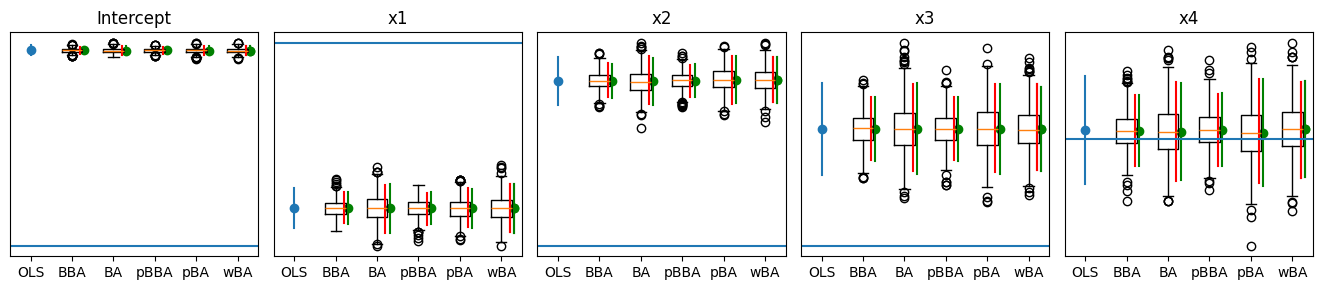

In [15]:
common.plot_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                         results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                         ncols=5)
plt.tight_layout()

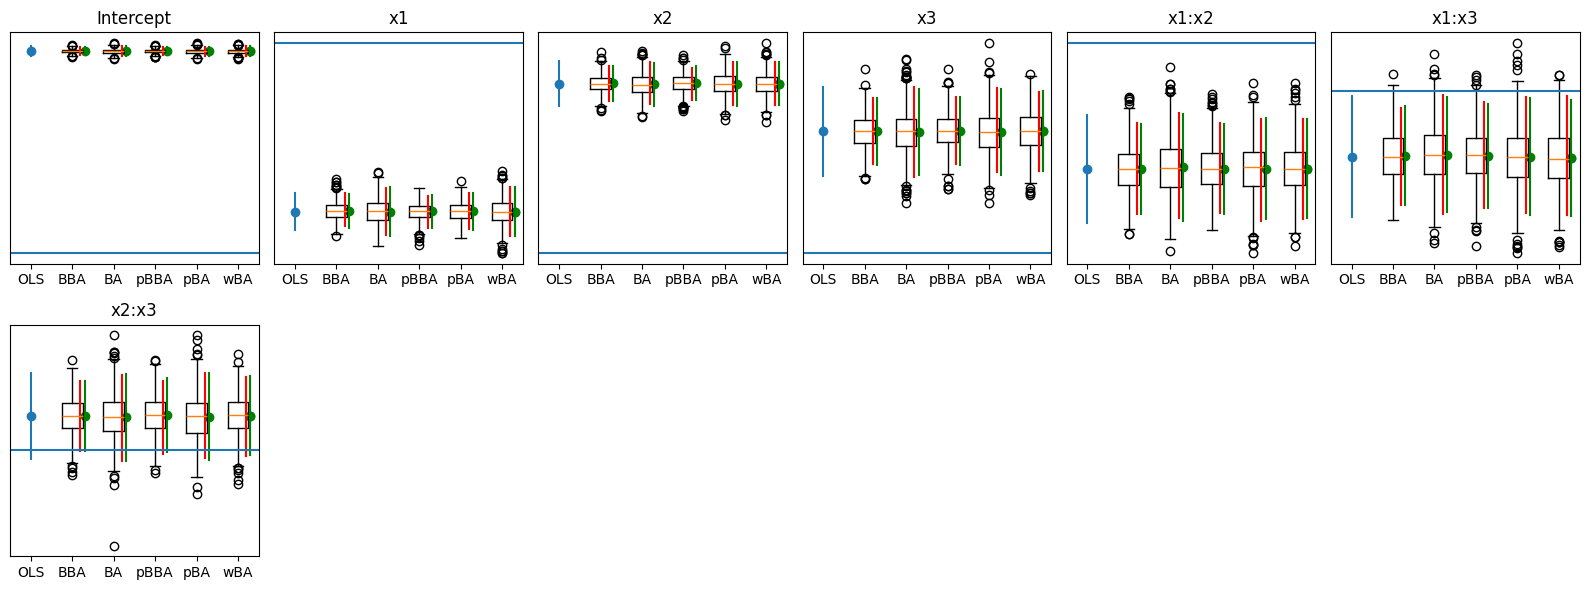

In [16]:
common.plot_coefficients(results['ols_interaction'], results['BBA_interaction'], results['BA_interaction'], 
                         results['pBBA_interaction'], results['pBA_interaction'], results['wBA_interaction'])
plt.tight_layout()

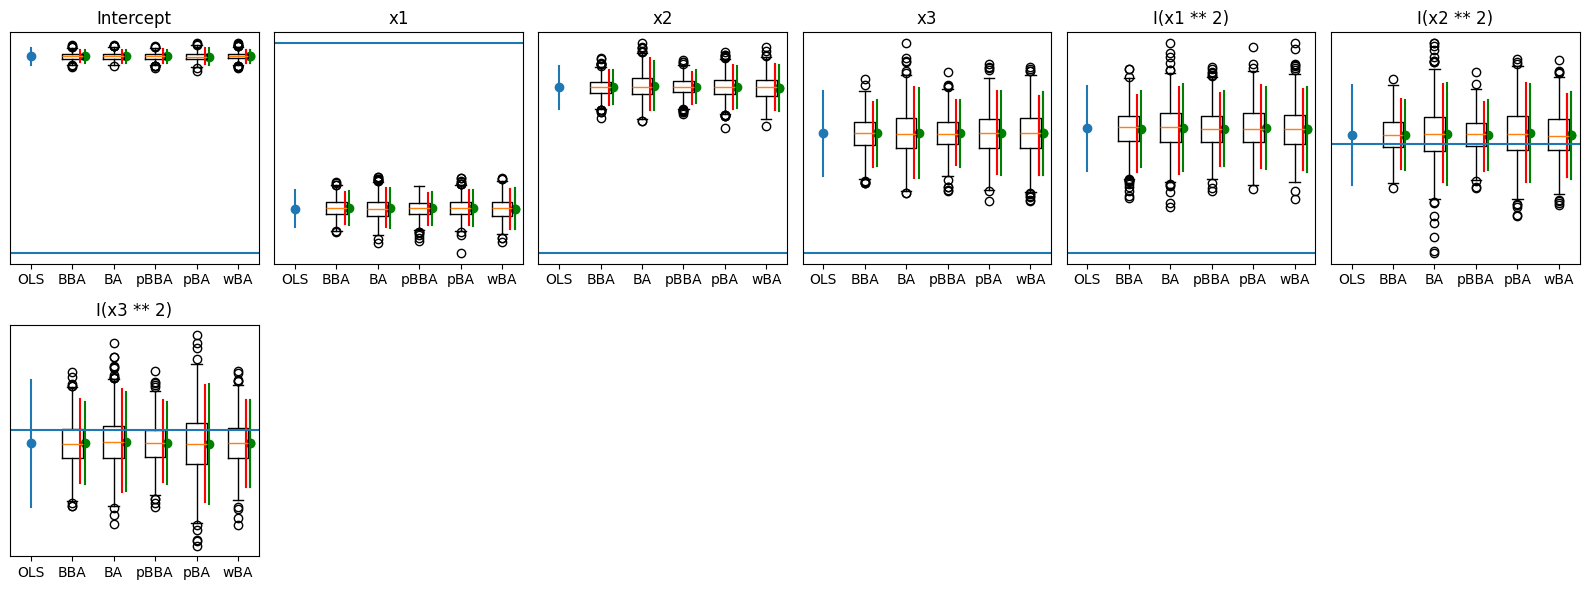

In [17]:
common.plot_coefficients(results['ols_quadratic'], results['BBA_quadratic'], results['BA_quadratic'], 
                         results['pBBA_quadratic'], results['pBA_quadratic'], results['wBA_quadratic'])
plt.tight_layout()

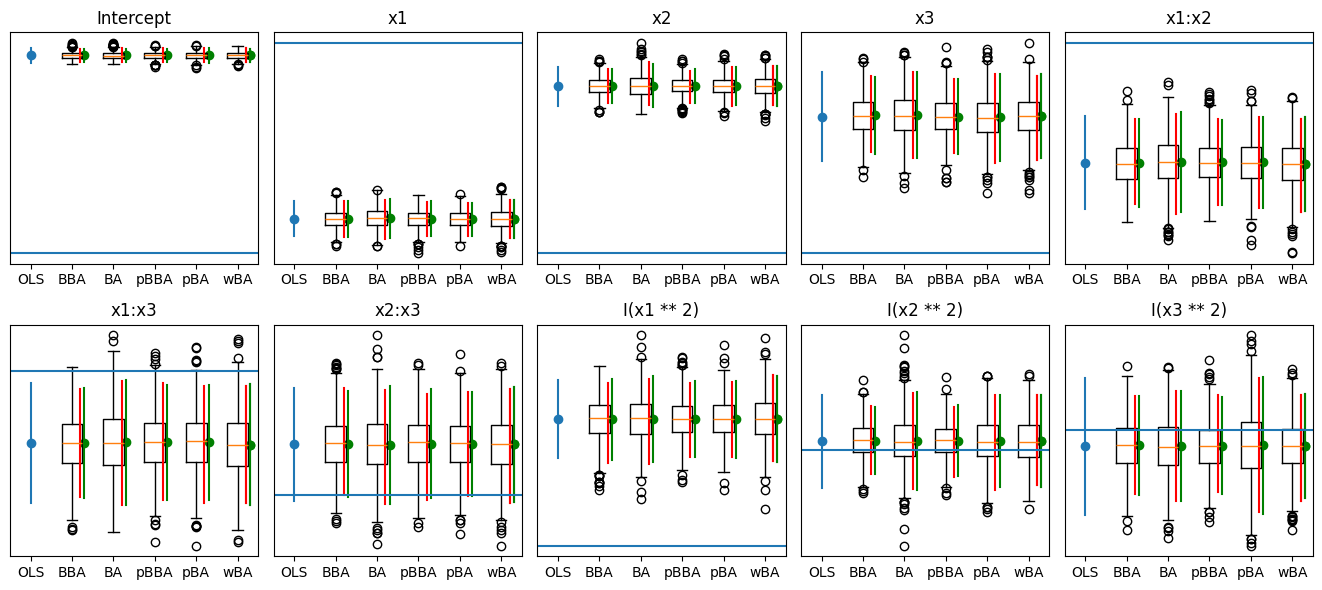

In [18]:
common.plot_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                         results['pBBA_full'], results['pBA_full'], results['wBA_full'],
                        ncols=5)
plt.tight_layout()

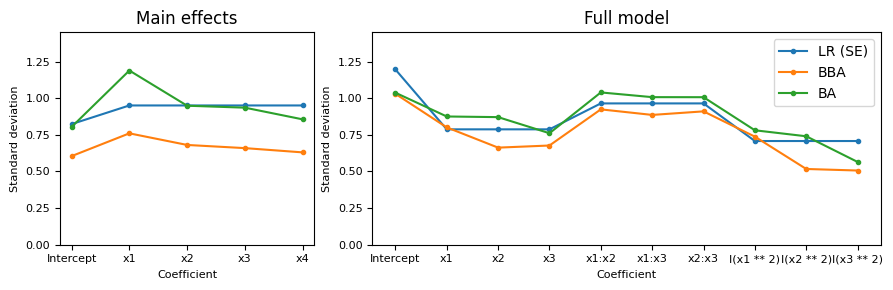

In [19]:
def plot_std_coefficients(ols_model, bba_samples, ba_samples, pbba_samples, pba_samples,
                          wba_samples, ax=None):
    std_df = pd.DataFrame({
        'LR (SE)': ols_model.bse,
        'BBA': bba_samples.agg(['mean', 'std']).transpose()['std'],
        'BA': ba_samples.agg(['mean', 'std']).transpose()['std'],
    })
    ax = std_df.plot(style='.-', ax=ax)
    ax.set_ylabel('Standard deviation')
    ax.set_xlabel('Coefficient')
    ax.set_ylim(0, std_df.max().max() * 1.05)
    ax.set_xticks(range(len(std_df)))
    ax.set_xticklabels(std_df.index)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)
    return ax

def summary_std_cofficients_pub(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3), width_ratios=[1, 2])


    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax.get_legend().remove()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()


summary_std_cofficients_pub(results, plot_std_coefficients=plot_std_coefficients)